# Transfer learning for COVID-19 Detection in X-Ray Images
## DD2424 Deep Learning - Group Project 

### Read Data

In [2]:
import matplotlib.pyplot as plt
import glob
import os
import cv2
import numpy as np

#### Filter difference between current generated dataset and paper dataset to get the correct data

In [3]:
def get_file_lines(filename):
    with open(filename) as f:
        content = f.readlines()
        
    file_lines = [x.strip() for x in content]
    return file_lines

def filter_out_difference(correct_data_description, wrong_data_description):
    correct_file_lines = get_file_lines(correct_data_description)
    wrong_file_lines = get_file_lines(wrong_data_description)
    
    nr_missing_images = 0
    
    # Need to check substrings as wrong_file_description has longer lines
    for correct_line in correct_file_lines:
        if not any(correct_line in line for line in wrong_file_lines):
            nr_missing_images += 1
                
    if nr_missing_images > 0:
        print('you are missing: ', nr_missing_images, 'images')
        return
    print('you have all images in ', correct_data_description)
    
    new_correct_upd_lines = []
    
    for wrong_line in wrong_file_lines:
        for correct_line in correct_file_lines:
            if correct_line in wrong_line:
                new_correct_upd_lines.append(wrong_line)
                   
    return new_correct_upd_lines
    
def write_line_list_to_file(file, line_list):
    with open(file, 'w') as filehandle:
        filehandle.writelines("%s\n" % line for line in line_list)
    


In [42]:
paper_test_data_description = 'data/paper_dataset_specifications/test_COVIDx2.txt'
paper_train_data_description = 'data/paper_dataset_specifications/train_COVIDx2.txt'

current_test_data_description = 'data/test_split_v3.txt'
current_train_data_description = 'data/train_split_v3.txt'

upd_test_set_list = filter_out_difference(paper_test_data_description, current_test_data_description)
upd_train_set_list = filter_out_difference(paper_train_data_description, current_train_data_description)


you have all images in  data/paper_dataset_specifications/test_COVIDx2.txt
you have all images in  data/paper_dataset_specifications/train_COVIDx2.txt


In [44]:
# writing updated and correct dataset description to txt file
# write_line_list_to_file('data/correct_test_split.txt',upd_test_set_list)
# write_line_list_to_file('data/correct_train_split.txt',upd_train_set_list)

### Class for handling data

In [5]:
class Dataset:
    def __init__(
            self,
            test_img_dir,
            train_img_dir,
            test_img_descriptions_file,
            train_img_descriptions_file,
            input_shape = (224, 224),
            batch_size = 10
                 ):
        self.test_img_dir = test_img_dir
        self.train_img_dir = train_img_dir
        self.test_img_descriptions = get_file_lines(test_img_descriptions_file)
        self.train_img_descriptions = get_file_lines(train_img_descriptions_file)
        self.input_shape = input_shape
        self.batch_size = batch_size
        self.batch_nr = 1
        self.max_batch = len(self.train_img_descriptions) // self.batch_size
        self.mapping = {
                'normal': 0,
                'pneumonia': 1,
                'COVID-19': 2}

        self.y_train = None
        self.y_test = None
        self.x_batch = None
        self.y_batch = None

    
    def get_current_batch(self):
        return self.x_batch, self.y_batch
    
    def _get_class_dist(self, y):
        class_dist = {}
        for class_name in self.mapping:
            class_dist[class_name] = np.count_nonzero(y == self.mapping[class_name])
        return class_dist

    def get_test_class_dist(self):
        test_class_dist = self._get_class_dist(self.y_test)

        return test_class_dist

    def read_test_data(self):
        self.x_test, self.y_test = self._read_correct_images(self.test_img_dir, self.test_img_descriptions)

    def _get_label(self, img_desc_list):
        for class_name in self.mapping:
            if class_name in img_desc_list:
                return self.mapping[class_name]
            
    # Must load training data in batches since memory error otherwise    
    def next_train_batch(self):
        
        if self.batch_nr == self.max_batch:
            print('No data left')
            return [], []
        
        start_img = (self.batch_nr-1) * self.batch_size
        end_img = (self.batch_nr) * self.batch_size        
                
        batch_descriptions = self.train_img_descriptions[start_img: end_img]
        
        self.x_batch, self.y_batch = self._read_correct_images(self.train_img_dir, batch_descriptions)
        
        self.batch_nr += 1
        

    def _read_correct_images(self, img_dir, img_descriptions):
        data_path = os.path.join(img_dir, '*g')
        images = glob.glob(data_path)
        
        x_list = []
        y_list = []
        
        for image_path in images:
            image_name = image_path.replace(img_dir + '/', '')
            for img_desc in img_descriptions:
                if image_name in img_desc:
                    img_desc_list = img_desc.split()
                    label = self._get_label(img_desc_list)
                    y_list.append(label)

                    img_array = cv2.imread(image_path)
                    resized_img_array = cv2.resize(img_array, self.input_shape)
                    x_list.append(resized_img_array)
                    
        y_array = np.array(y_list)
        x_array = np.array(x_list)        

        return x_array, y_array

### Demo loading data

In [6]:
test_data = 'data/dataset/test'
test_data_description = 'data/correct_test_split.txt'

train_data = 'data/dataset/train'
train_data_description = 'data/correct_train_split.txt'

dataset = Dataset(
        test_data,
        train_data,
        test_data_description,
        train_data_description
       )

# generate first batch of training data
dataset.next_train_batch()

# Read test data
dataset.read_test_data()

print(dataset.get_test_class_dist())

{'normal': 100, 'pneumonia': 100, 'COVID-19': 31}


In [7]:
x_train, y_train = dataset.get_current_batch()

In [8]:
x_train.shape

(10, 224, 224, 3)

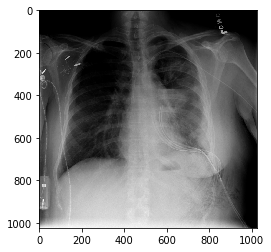

In [17]:
# Testing to read an image
path = 'data/dataset/playground_dataset/0a6a5956-58cf-4f17-9e39-7e0d17310f67.png'
img = cv2.imread(path,0)

plt.imshow(img, cmap='gray')
plt.show()

### Proof of concept with simple ML model

### Pretrained VGG-16

### CNN Model from Scratch